In [8]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import h5py
import os
import seaborn as sns
from pyscf.scf.uhf import det_ovlp

In [2]:
# Wavefunction generation
from pyscf import lib, gto, scf
from pyscf import gto, mp, mcscf
def HF_casci(scf_checkfile, ci_checkfile):
    mol = gto.M(
        atom="H 0. 0. 0.0; F 0. 0. 0.8",
        basis=f"ccecpccpvdz",
        unit="bohr",
        charge=0,
        spin=0,
        verbose=1,
    )
    mf = scf.UHF(mol).run()
    mf.chkfile = scf_checkfile
    mf.kernel()
    mc = mcscf.CASCI(mf, 3,2)
    # mc.fcisolver.nroots = 4
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff    
    return mol, mf, mc

In [3]:
# Wavefunction generation
from pyscf import lib, gto, scf
from pyscf import gto, mp, mcscf
def H2_casci(scf_checkfile, ci_checkfile):
    mol = gto.M(
        atom="H 0. 0. 0.0; H 0. 0. 1.4",
        basis=f"ccecpccpvqz",
        unit="bohr",
        charge=0,
        spin=0,
        verbose=1,
    )
    mf = scf.UHF(mol).run()
    mf.chkfile = scf_checkfile
    mf.kernel()
    mc = mcscf.CASCI(mf, 3,2)
    # mc.fcisolver.nroots = 4
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff    
    return mol, mf, mc

In [4]:
scf_checkfile = 'rohf.chk'
ci_checkfile = 'casci.chk'
for fname in [scf_checkfile, ci_checkfile]:
    if os.path.isfile(fname):
        os.remove(fname)
mol, mf, mcc = H2_casci(scf_checkfile, ci_checkfile)
# mol, mf, mcc = HF_casci(scf_checkfile, ci_checkfile)

dict_keys(['mol', '_scf', 'verbose', 'stdout', 'max_memory', 'ncas', 'nelecas', '_ncore', 'fcisolver', 'frozen', 'extrasym', 'e_tot', 'e_cas', 'ci', 'mo_coeff', 'mo_energy', 'mo_occ', 'converged'])


In [5]:
# Orthogonality test

<Axes: >

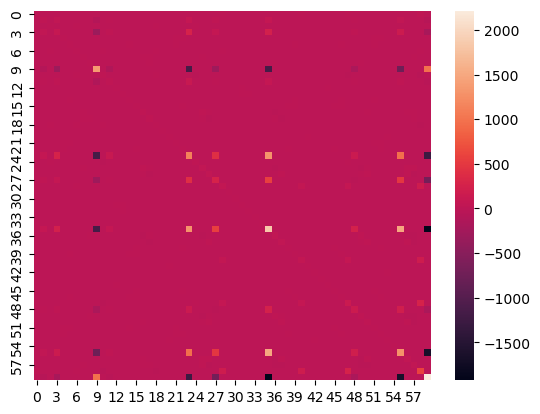

In [6]:
# FC = SCE Roothaan equation
C = mf.mo_coeff
Ca = C[0]
# C.T @ C
s0 = np.einsum('ij, jk->ik', Ca.T, Ca)
sns.heatmap(s0)

<Axes: >

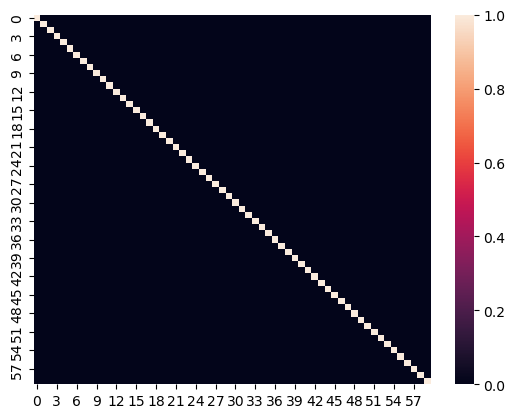

In [7]:
# C.T @ S @ C
s1 = np.einsum('ij, jk, kl->il', Ca.T, mf.get_ovlp(), Ca)
sns.heatmap(s1)
# Orthogonal in the overlap metric (get_ovlp)

# Using PYSCF method using output from PYQMC_1

In [8]:
import bosonslater 
import pyscftools, mc
wf1 = bosonslater.BosonWF(mol, mf, mc=mcc)

nconfig = 1000
mol, mf = pyscftools.recover_pyscf(scf_checkfile)
configs = mc.initial_guess(mol, nconfig)
# wf.parameters['det_coeff'] = np.ones(len(wf.parameters['det_coeff']))
signb, phib = wf1.recompute(configs)
num_ao = wf1._aovals.shape[-1]
print(num_ao)

60


In [9]:
det_dim_up = wf1._dets[0][1].shape[-1]
det_dim = det_dim_up
print(det_dim_up, ' up determinants')

3  up determinants


In [10]:
det_dim_dn = wf1._dets[1][1].shape[-1]
print(det_dim_dn, ' down determinants')
print(det_dim_up * det_dim_dn, ' total number of determinants')


3  down determinants
9  total number of determinants


In [11]:
mcc_mo_coeff=copy.deepcopy(mf.mo_coeff)

In [14]:
n = np.array(wf1._det_occup)
print(n.shape)
occ_arr_shape = (n.shape[0], n.shape[1], num_ao)
occ_arr = np.zeros(occ_arr_shape)
for i in range(n.shape[0]):
    for j in range(n.shape[1]):
        occ_arr[i,j][n[i,j]]=1

(2, 3, 1)


In [15]:
occ_arr.shape

(2, 3, 60)

In [16]:
ovlp_mat = np.zeros((det_dim, det_dim))
for i1 in range(det_dim):
    for i2 in range(det_dim):
        det1_occ = np.array([occ_arr[0, i1], occ_arr[1, i1]])
        det2_occ = np.array([occ_arr[0, i2], occ_arr[1, i2]])
        # print(det1_occ, '\n\n', det2_occ, '\n===\n')
        ovlp, _ = det_ovlp(mcc_mo_coeff, mcc_mo_coeff, det1_occ, det2_occ, mf.get_ovlp())
        ovlp_mat[i1, i2] = ovlp

/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/scf/uhf.py:712: RuntimeWarning: divide by zero encountered in reciprocal
  x_b = reduce(numpy.dot, (u_b*numpy.reciprocal(s_b), vt_b))


<Axes: >

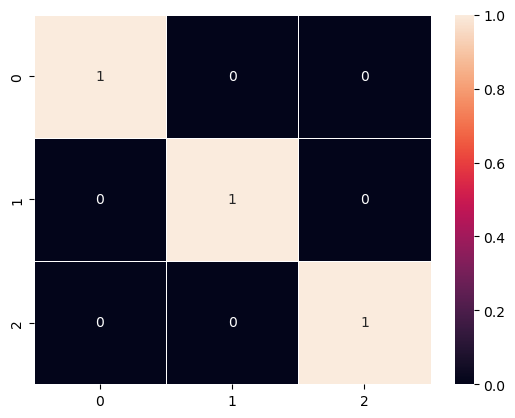

In [17]:
sns.heatmap(np.round(ovlp_mat,5), annot=True, linewidths=.5)

# PYSCF method 2

In [18]:
import bosonslater 
import pyscftools, mc
wf1 = bosonslater.BosonWF(mol, mf, mc=mcc)

nconfig = 1000
mol, mf = pyscftools.recover_pyscf(scf_checkfile)
configs = mc.initial_guess(mol, nconfig)
# wf.parameters['det_coeff'] = np.ones(len(wf.parameters['det_coeff']))
signb, phib = wf1.recompute(configs)
num_ao = wf1._aovals.shape[-1]
print(num_ao)

60


In [19]:
wf1._aovals.shape

(1, 1000, 2, 60)

In [32]:
det_dim_up = wf1._dets[0][1].shape[-1]
print(det_dim_up, ' up determinants')

3  up determinants


In [33]:
det_dim_dn = wf1._dets[1][1].shape[-1]
print(det_dim_dn, ' down determinants')
det_dim = det_dim_up * det_dim_dn
print(det_dim, ' total number of determinants')

3  down determinants
9  total number of determinants


In [34]:
occ_arr = np.zeros((2,det_dim, 60))
for i in range(det_dim):
    up_i = wf1._det_map[0,i]
    dn_i = wf1._det_map[1,i]
    occ_arr[0, i][wf1._det_occup[0][up_i]] = 1
    occ_arr[1, i][wf1._det_occup[1][dn_i]] = 1
occ_arr.shape    

(2, 9, 60)

In [38]:
ovlp_mat = np.zeros((det_dim, det_dim))
mf_ovlp = mf.get_ovlp()
# mf_ovlp = np.eye(mf_ovlp.shape[0])
for i1 in range(det_dim):
    for i2 in range(det_dim):
        det1_occ = occ_arr[:, i1, :]
        det2_occ = occ_arr[:, i2, :]
        # print(det1_occ, '\n\n', det2_occ, '\n===\n')
        ovlp, _ = det_ovlp(mcc_mo_coeff, mcc_mo_coeff, det1_occ, det2_occ, mf_ovlp)
        ovlp_mat[i1, i2] = ovlp

<Axes: >

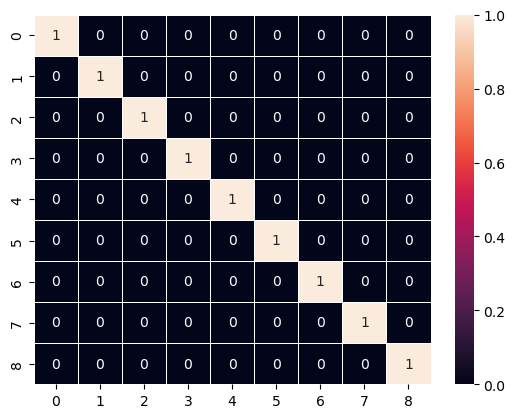

In [39]:
sns.heatmap(np.round(ovlp_mat,5), annot=True, linewidths=.5)

# Using QMC one step

In [40]:
import bosonslater 
import pyscftools, mc
wf1 = bosonslater.BosonWF(mol, mf, mc=mcc)

nconfig = 1000
mol, mf = pyscftools.recover_pyscf(scf_checkfile)
configs = mc.initial_guess(mol, nconfig)
signb, phib = wf1.recompute(configs)
sign, logval = wf1.value()
val = np.exp(logval)
rho = val**2 
rho.shape

(1000,)

In [41]:
wf1.parameters['det_coeff']
wf1._det_map

array([[0, 0, 0, 1, 1, 1, 2, 2, 2],
       [0, 1, 2, 0, 1, 2, 0, 1, 2]])

In [42]:
# import slater 
# import pyscftools, mc
# wfs = slater.Slater(mol, mf, mc=mcc)

# nconfig = 1000
# mol, mf = pyscftools.recover_pyscf(scf_checkfile)
# configs = mc.initial_guess(mol, nconfig)
# signb, phib = wfs.recompute(configs)
# sign, logval = wfs.value()
# val = np.exp(logval)
# rho_s = val**2 
# rho_s.shape

In [43]:
# wfs.parameters['det_coeff']
# wfs._det_map

In [44]:
# rho

In [45]:
updet_sign, updet_val = wf1._dets[0]
dndet_sign, dndet_val = wf1._dets[1]

In [46]:
nup_i = np.einsum('ni, ni->ni', updet_sign, np.exp(updet_val)) # ui
nup_ij = np.einsum('ni, nj->nij', nup_i, nup_i) # ui
nup_i.shape

(1000, 3)

In [47]:
nup_i.shape

(1000, 3)

In [48]:
mf.get_ovlp().shape

(60, 60)

In [49]:
nup = np.einsum('ni, ni, nj, nj->nij', updet_sign, np.exp(updet_val), updet_sign, np.exp(updet_val)) # ui * uj
ndn = np.einsum('ni, ni, nj, nj->nij', dndet_sign, np.exp(dndet_val), dndet_sign, np.exp(dndet_val)) # di * dj 
psi_i = np.einsum('ni, ni, ni, ni->ni', updet_sign, np.exp(updet_val), dndet_sign, np.exp(dndet_val)) # ui * di 
nup.shape

(1000, 3, 3)

(3, 3)


<Axes: >

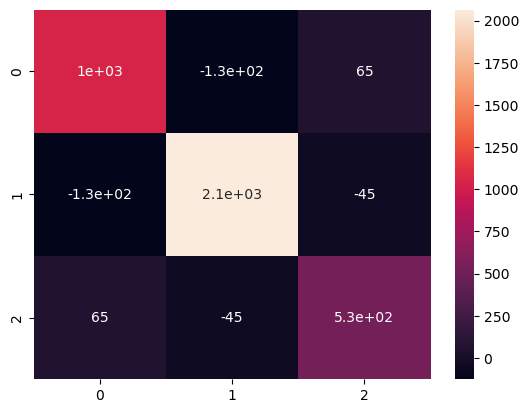

In [50]:
ovlp_ij = np.einsum('nij, nij, n ->ij', nup, ndn, 1./rho) # w(R) * (ui * uj) * (di * dj), w = 1 / rho
print(ovlp_ij.shape)
sns.heatmap(ovlp_ij, annot=True)

In [51]:
norm_i = np.einsum('ni, ni, n ->i', psi_i, psi_i, 1./rho) # ni = < psi_i * psi_i / rho > 
norm_ij = np.sqrt(np.einsum('i, j ->ij', norm_i, norm_i)) # sqrt(ni * nj)
print(norm_ij.shape)
norm_ij

(3, 3)


array([[1045.22742455, 1469.13699865,  743.27733388],
       [1469.13699865, 2064.97023528, 1044.72596662],
       [ 743.27733388, 1044.72596662,  528.55596981]])

<Axes: >

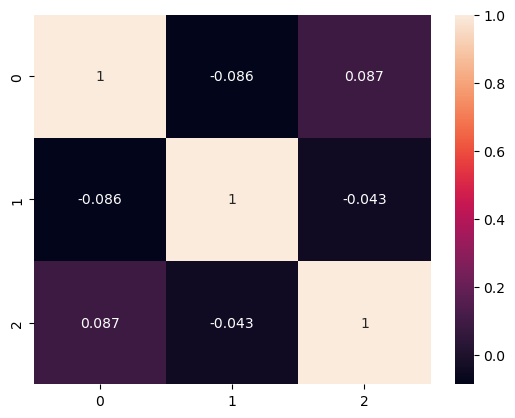

In [52]:
mat = ovlp_ij/norm_ij
sns.heatmap(mat, annot=True)

# Using QMC one step number 2

In [53]:
import bosonslater 
import pyscftools, mc
wf1 = bosonslater.BosonWF(mol, mf, mc=mcc)

nconfig = 1000
mol, mf = pyscftools.recover_pyscf(scf_checkfile)
configs = mc.initial_guess(mol, nconfig)
signb, phib = wf1.recompute(configs)
sign, logval = wf1.value()
val = np.exp(logval)
rho = val**2 
rho.shape

(1000,)

In [54]:
wf1._det_occup[0]

[[0], [1], [2]]

In [55]:
i = 0
j = 2
print((wf1._det_map[0][i], wf1._det_map[1][i]), (wf1._det_map[0][j], wf1._det_map[1][j]))

(0, 0) (0, 2)


In [56]:
i = 0
j = 6
print((wf1._det_map[0][i], wf1._det_map[1][i]), (wf1._det_map[0][j], wf1._det_map[1][j]))

(0, 0) (2, 0)


In [57]:
i = 1
j = 7
print((wf1._det_map[0][i], wf1._det_map[1][i]), (wf1._det_map[0][j], wf1._det_map[1][j]))

(0, 1) (2, 1)


In [58]:
i = 3
j = 5
print((wf1._det_map[0][i], wf1._det_map[1][i]), (wf1._det_map[0][j], wf1._det_map[1][j]))

(1, 0) (1, 2)


In [59]:
wf1._det_occup

[[[0], [1], [2]], [[0], [1], [2]]]

In [60]:
updet_sign, updet_val = wf1._dets[0][:, :, wf1._det_map[0]]
dndet_sign, dndet_val = wf1._dets[1][:, :, wf1._det_map[1]]

In [61]:
nup = np.einsum('ni, ni, nj, nj->nij', updet_sign, np.exp(updet_val), updet_sign, np.exp(updet_val)) # ui * uj
ndn = np.einsum('ni, ni, nj, nj->nij', dndet_sign, np.exp(dndet_val), dndet_sign, np.exp(dndet_val)) # di * dj 
psi_i = np.einsum('ni, ni, ni, ni->ni', updet_sign, np.exp(updet_val), dndet_sign, np.exp(dndet_val)) # ui * di 
nup.shape


(1000, 9, 9)

(9, 9)


<Axes: >

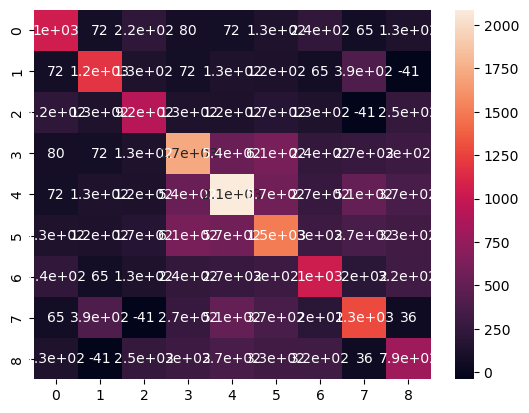

In [62]:
ovlp_ij = np.einsum('nij, nij, n ->ij', nup, ndn, 1./rho) # w(R) * (ui * uj) * (di * dj), w = 1 / rho
print(ovlp_ij.shape)
sns.heatmap(ovlp_ij, annot=True)

In [63]:
norm_i = np.einsum('ni, ni, n ->i', psi_i, psi_i, 1./rho) # ni = < psi_i * psi_i / rho > 
norm_ij = np.sqrt(np.einsum('i, j ->ij', norm_i, norm_i)) # sqrt(ni * nj)
print(norm_ij.shape)
norm_ij

(9, 9)


array([[1047.00894525, 1112.42601391,  983.24014708, 1342.68223996,
        1478.56067752, 1254.20897787, 1042.35668586, 1159.37903395,
         910.79086051],
       [1112.42601391, 1181.93033787, 1044.67294428, 1426.57296188,
        1570.94107769, 1332.57189462, 1107.48308157, 1231.81698035,
         967.69702977],
       [ 983.24014708, 1044.67294428,  923.35523131, 1260.90525691,
        1388.507925  , 1177.82051955,  978.87123674, 1088.76625842,
         855.31851825],
       [1342.68223996, 1426.57296188, 1260.90525691, 1721.85309942,
        1896.10334411, 1608.39515978, 1336.71619154, 1486.78542368,
        1167.99643238],
       [1478.56067752, 1570.94107769, 1388.507925  , 1896.10334411,
        2087.98758312, 1771.16354591, 1471.99086946, 1637.24699555,
        1286.19679698],
       [1254.20897787, 1332.57189462, 1177.82051955, 1608.39515978,
        1771.16354591, 1502.41329581, 1248.63604984, 1388.8167811 ,
        1091.03372937],
       [1042.35668586, 1107.48308157,  9

<Axes: >

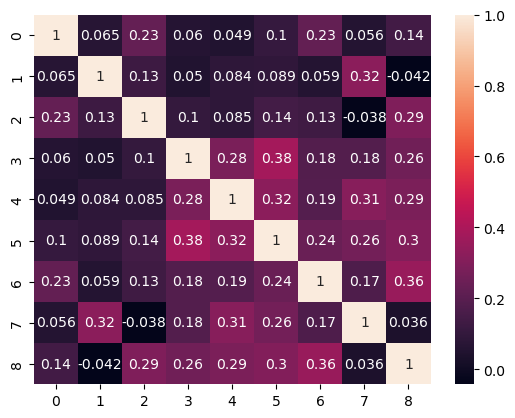

In [64]:
mat = ovlp_ij/norm_ij
sns.heatmap(mat, annot=True)

# QMC single step try 3

In [65]:
import bosonslater 
import pyscftools, mc
boson_wf = bosonslater.BosonWF(mol, mf, mc=mcc)

nconfig = 1000
mol, mf = pyscftools.recover_pyscf(scf_checkfile)
configs = mc.initial_guess(mol, nconfig)
signb, phib = boson_wf.recompute(configs)
sign, logval = boson_wf.value()
val = np.exp(logval)
rho = val**2 
rho.shape

(1000,)

In [75]:
updet_sign, updet_val = boson_wf._dets[0][:, :, boson_wf._det_map[0]]
dndet_sign, dndet_val = boson_wf._dets[1][:, :, boson_wf._det_map[1]]

det_dim_up = boson_wf._dets[0][1].shape[-1]
det_dim_dn = boson_wf._dets[1][1].shape[-1]
det_dim = det_dim_up * det_dim_dn

occ_arr_shape = (2, det_dim, num_ao)
occ_arr = np.zeros(occ_arr_shape)
for i in range(det_dim):
    up_i = boson_wf._det_map[0,i]
    dn_i = boson_wf._det_map[1,i]
    occ_arr[0, i][boson_wf._det_occup[0][up_i]] = 1
    occ_arr[1, i][boson_wf._det_occup[1][dn_i]] = 1



In [76]:
nup_i = np.einsum('ni, ni->ni', updet_sign, np.exp(updet_val)) # ui
ndn_i = np.einsum('ni, ni->ni', dndet_sign, np.exp(dndet_val)) # uj


mf_ovlp = mf.get_ovlp()
ovlp = np.einsum('io, op, jp->ij',occ_arr[0], mf_ovlp, occ_arr[0])


In [77]:
nup_ij = np.einsum('ni, ij, nj->nij', nup_i, ovlp, nup_i) # ui * uj
ndn_ij = np.einsum('ni, ij, nj->nij', ndn_i, ovlp, ndn_i) # ui * uj

ovlp_ij = np.einsum('nij, nij, n ->ij', nup_ij, ndn_ij, 1./rho) # w(R) * (ui * uj) * (di * dj), w = 1 / rho
# ovlp_ij_avg = np.average(ovlp_ij, axis=0)

psi_i = np.einsum('ni, ni, ni, ni->ni', updet_sign, np.exp(updet_val), dndet_sign, np.exp(dndet_val)) # ui * di 
norm_i = np.einsum('ni, ni, n ->i', psi_i, psi_i, 1./rho)
norm_ij = np.sqrt(np.einsum('i, j ->ij', norm_i, norm_i)) # sqrt(ni * nj)


<Axes: >

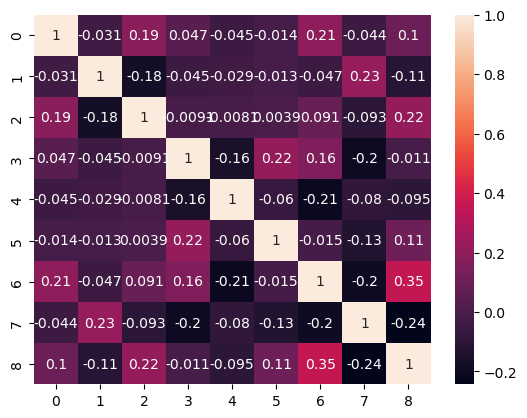

In [78]:
mat = ovlp_ij/norm_ij
sns.heatmap(mat, annot=True)

# Testing in parallel code

In [163]:
import h5py 
import numpy as np
import copy
import matplotlib.pyplot as plt
f = h5py.File("abvmc.hdf5", "r")

In [164]:
f.keys()

<KeysViewHDF5 ['acceptance', 'block', 'configs', 'energycorr', 'energyee', 'energyei', 'energygrad2', 'energyii', 'energyka', 'energykb', 'energyke', 'energytotal', 'energyvh', 'energyvxc', 'excitationsdelta', 'excitationsovlp_ij', 'nconfig']>

In [238]:
def plot_delta_ovlp(filename="abvmc.hdf5", discard = 2):
    f = h5py.File(filename, "r")    

    fig, ax = plt.subplots(3, 2, figsize = (12, 15))    
    ovlp_ij_raw=np.array(f['excitationsovlp_ij'])
    delta_ij_raw=np.array(f['excitationsdelta'])
    discard = 2
    ovlp_ij = np.average(ovlp_ij_raw[discard:], axis=0)
    # plt.figure()
    sns.heatmap(ovlp_ij, ax=ax[0, 0]) #, annot=True)
    ax[0, 0].set_title('Overlap matrix')
    # plt.title('Overlap matrix')

    ovlp_ij_std = np.std(ovlp_ij_raw[discard:], axis=0)
    sns.heatmap(ovlp_ij_std, ax=ax[1, 0]) #, annot=True)
    ax[1, 0].set_title('Standard deviation of overlap matrix')
    
    filtered_ovlp_ij = copy.deepcopy(ovlp_ij)
    filtered_ovlp_ij[ovlp_ij_std>np.abs(ovlp_ij)] = 0
    sns.heatmap(filtered_ovlp_ij, ax=ax[2, 0]) #, annot=True)
    ax[2, 0].set_title('Filtered overlap matrix')
    


    delta_ij = np.average(delta_ij_raw[discard:], axis=0)
    sns.heatmap(delta_ij, ax=ax[0, 1]) #, annot=True)
    ax[0, 1].set_title('Delta matrix')
                       
    delta_ij_std = np.std(delta_ij_raw[discard:], axis=0)
    sns.heatmap(delta_ij_std, ax=ax[1, 1]) #, annot=True)
    ax[1, 1].set_title('Standard deviation of delta matrix')
    

    filtered_delta_ij = copy.deepcopy(delta_ij)
    filtered_delta_ij[delta_ij_std>np.abs(delta_ij)] = 0
    sns.heatmap(filtered_delta_ij, ax=ax[2, 1]) #, annot=True)
    ax[2, 1].set_title('Filtered Delta matrix')
    
    return {'filtered': [filtered_ovlp_ij, filtered_delta_ij], 
            'raw': [ovlp_ij_raw, delta_ij_raw]}
# res = plot_delta_ovlp()

array([0.        , 0.00583007, 0.01374889, 0.01471505, 0.01573565,
       0.01893445, 0.02026899, 0.02177901, 0.02383914, 0.0245848 ,
       0.0289529 , 0.02926322, 0.03060697, 0.03397431, 0.03446981,
       0.0358321 , 0.03677719, 0.03772734, 0.03786808, 0.03825292,
       0.0391275 , 0.04258884, 0.0442062 , 0.04530186, 0.04721172,
       0.04739693, 0.04762192, 0.04837779, 0.0485818 , 0.04925167,
       0.04927594, 0.04967498, 0.04980133, 0.0505749 , 0.05129741,
       0.05174824, 0.05187359, 0.05268373, 0.05273196, 0.05277919,
       0.05403791, 0.05418707, 0.05453213, 0.05457918, 0.05511762,
       0.05550658, 0.05605517, 0.05616803, 0.05670088, 0.05799627,
       0.05851146, 0.05889878, 0.05901284, 0.0590296 , 0.05914927,
       0.06003484, 0.06018767, 0.06378906, 0.06382799, 0.06392073,
       0.06412913, 0.06596807, 0.06607931, 0.06623784, 0.06696365,
       0.06810144, 0.07098134, 0.07118312, 0.07147031, 0.07184143,
       0.07335343, 0.07455556, 0.07468839, 0.07479503, 0.07519

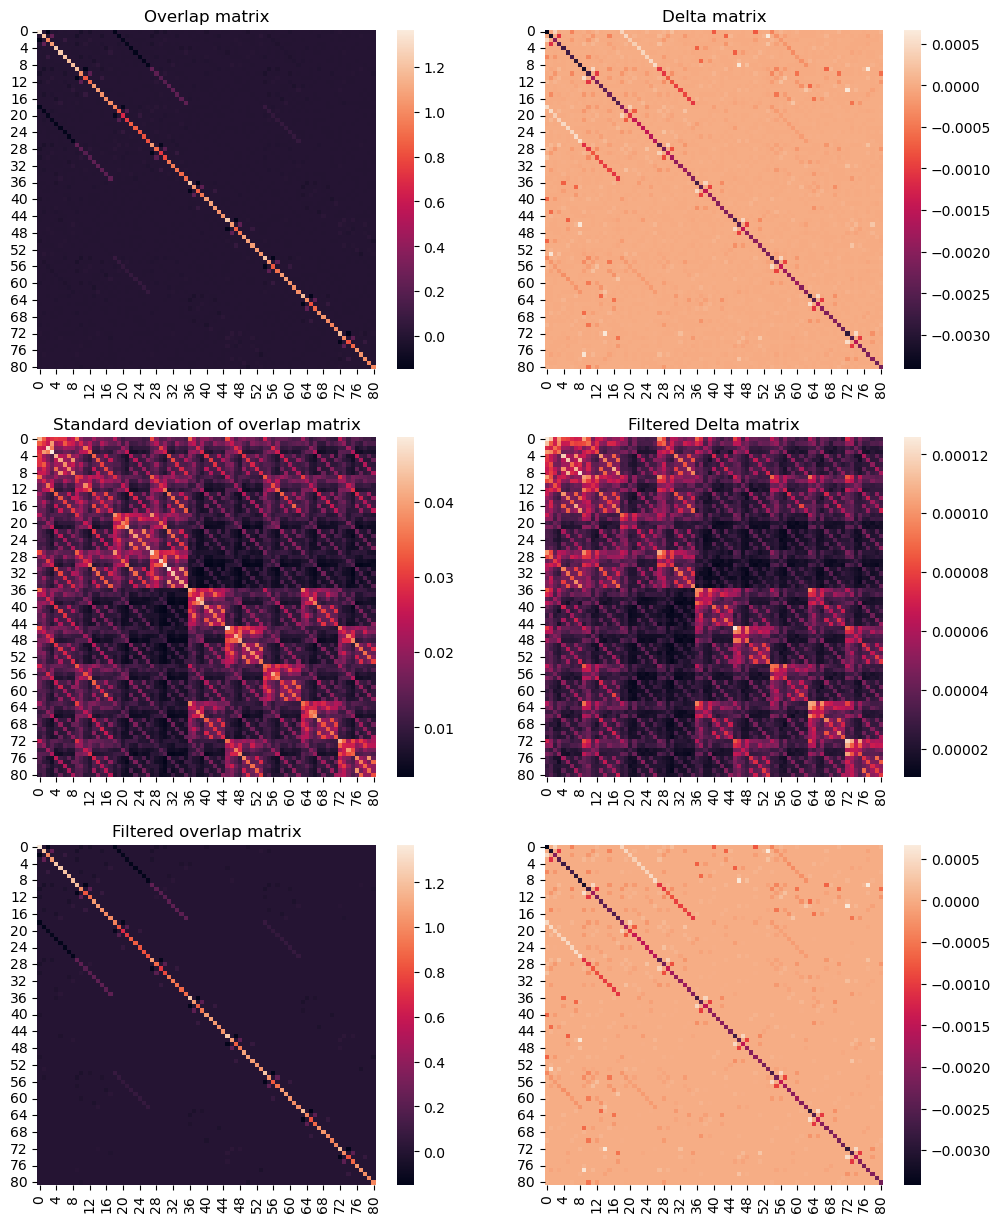

In [233]:
res = plot_delta_ovlp("abvmc-81.hdf5")
s, delta = res['filtered']
sinv = np.linalg.inv(s)
m = np.matmul(sinv, delta)
e, v = np.linalg.eigh(m)
(e-e[0]) * 27.211

array([0.        , 0.02431004, 0.040657  , 0.04493424, 0.06212312,
       0.06220206, 0.06660575, 0.06663673, 0.07039299, 0.07044286,
       0.0869049 , 0.09049775, 0.09087582, 0.09356295, 0.10851428,
       0.11058569, 0.11063912, 0.11734824, 0.11911468, 0.11956184,
       0.12029475, 0.12190603, 0.12636259, 0.13832179, 0.13847982,
       0.14614033, 0.14622224, 0.1468988 , 0.14699342, 0.15022241,
       0.15024274, 0.15043511, 0.15898179, 0.15931333, 0.17714595,
       0.18166381])

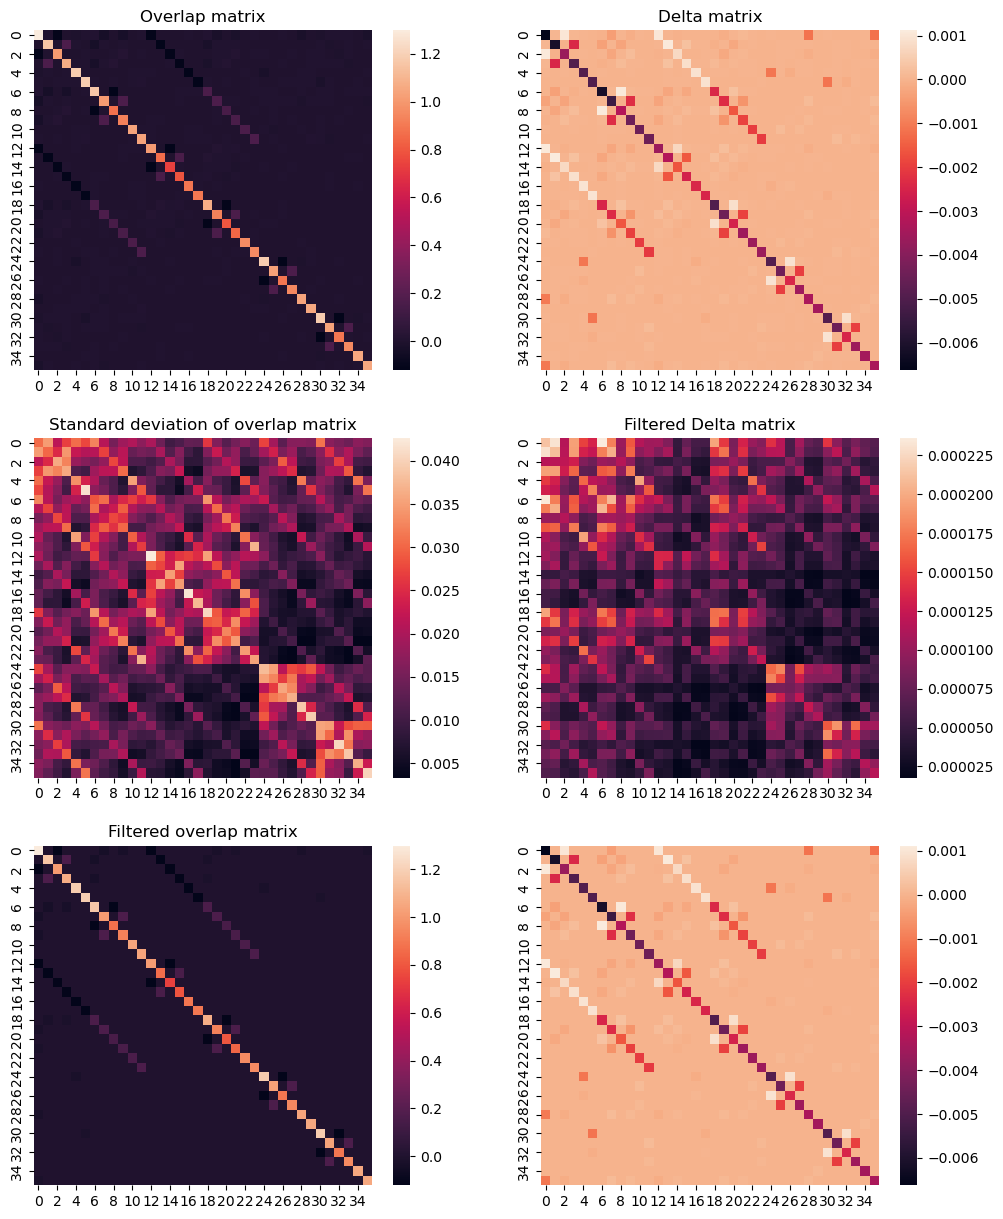

In [232]:
res = plot_delta_ovlp("abvmc-36.hdf5")
s, delta = res['filtered']
sinv = np.linalg.inv(s)
m = np.matmul(sinv, delta)
e, v = np.linalg.eigh(m)
(e-e[0]) * 27.211


array([0.        , 0.03025706, 0.03259008, 0.07892232, 0.16133118,
       0.17144957, 0.2080944 , 0.23554263, 0.34307159])

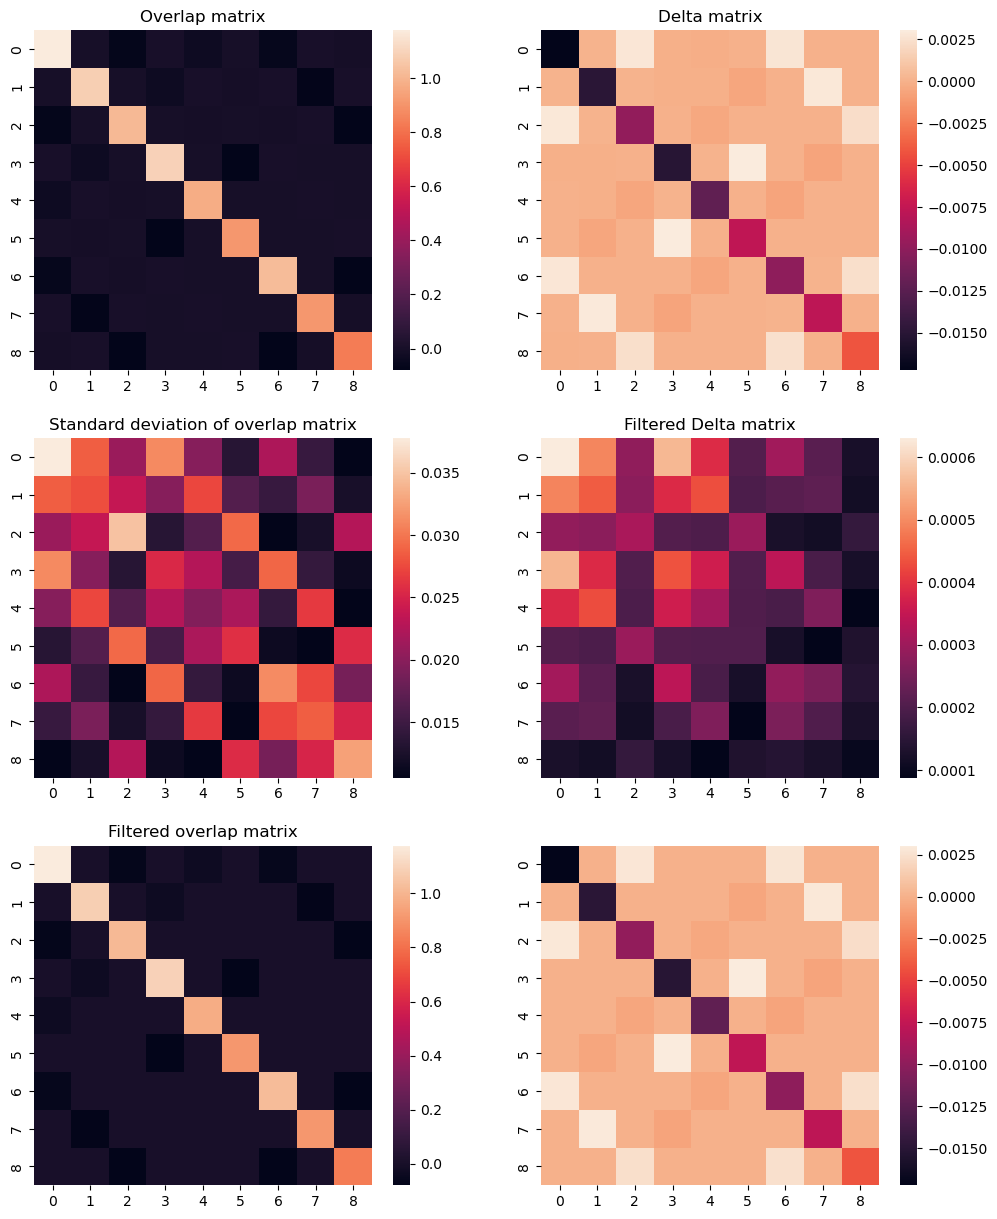

In [234]:
res = plot_delta_ovlp("abvmc-9.hdf5")
s, delta = res['filtered']
sinv = np.linalg.inv(s)
m = np.matmul(sinv, delta)
e, v = np.linalg.eigh(m)
(e-e[0]) * 27.211

array([0.        , 0.04981711, 0.19064865, 0.20110229, 0.27470575,
       0.88857198, 1.09835216, 1.15551649, 1.38799091])

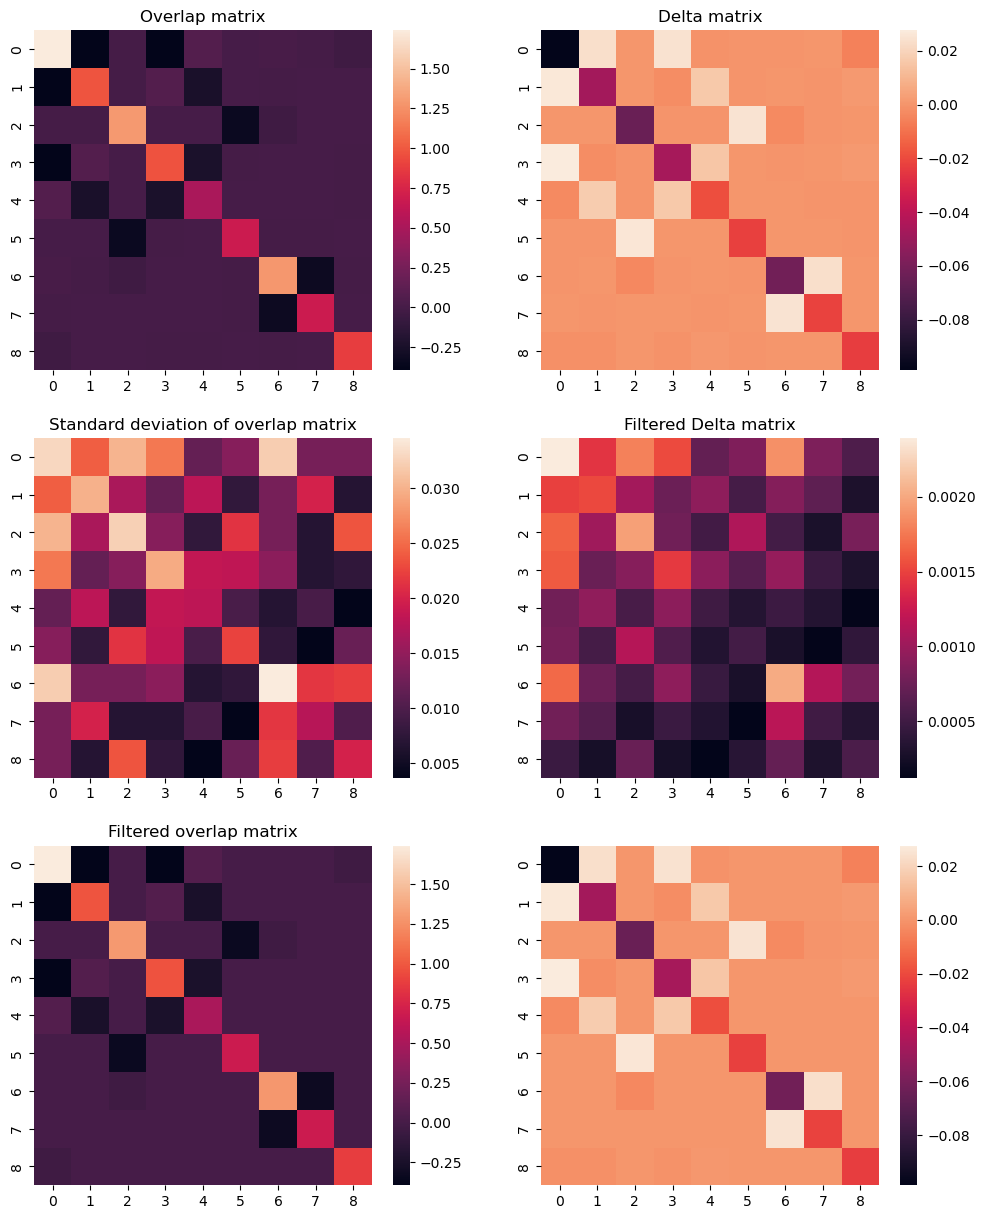

In [236]:
res = plot_delta_ovlp("abvmc-he.hdf5")
s, delta = res['filtered']
sinv = np.linalg.inv(s)
m = np.matmul(sinv, delta)
e, v = np.linalg.eigh(m)
(e-e[0]) * 27.211

array([0.        , 0.01872012, 0.03328012, 0.05911023, 0.07354892,
       0.0816207 , 0.09198776, 0.10589936, 0.12163386, 0.14836239,
       0.15299722, 0.16498083, 0.16828963, 0.20108905, 0.20880526,
       0.25232231, 0.29498149, 0.33408504, 0.33658778, 0.35106096,
       0.35396795, 0.35689145, 0.36276435, 0.38051413, 0.40998934,
       0.41913477, 0.42347472, 0.42628841, 0.43577376, 0.43752435,
       0.44231475, 0.44541816, 0.44718748, 0.4570289 , 0.46279896,
       0.46983045, 0.47042082, 0.47557304, 0.48346211, 0.48807178,
       0.49061389, 0.4948443 , 0.49615022, 0.50226319, 0.50579009,
       0.50842022, 0.51180181, 0.51941948, 0.5237052 , 0.52685015,
       0.52981065, 0.53153835, 0.53272318, 0.53482217, 0.53625739,
       0.53804286, 0.54061948, 0.5415038 , 0.54414863, 0.54678109,
       0.55220464, 0.55572215, 0.55797924, 0.56351332, 0.56605652,
       0.57507001, 0.58692752, 0.60369604, 0.61055028, 0.61466171,
       0.63732444, 0.64956636, 0.65232207, 0.65524767, 0.66001

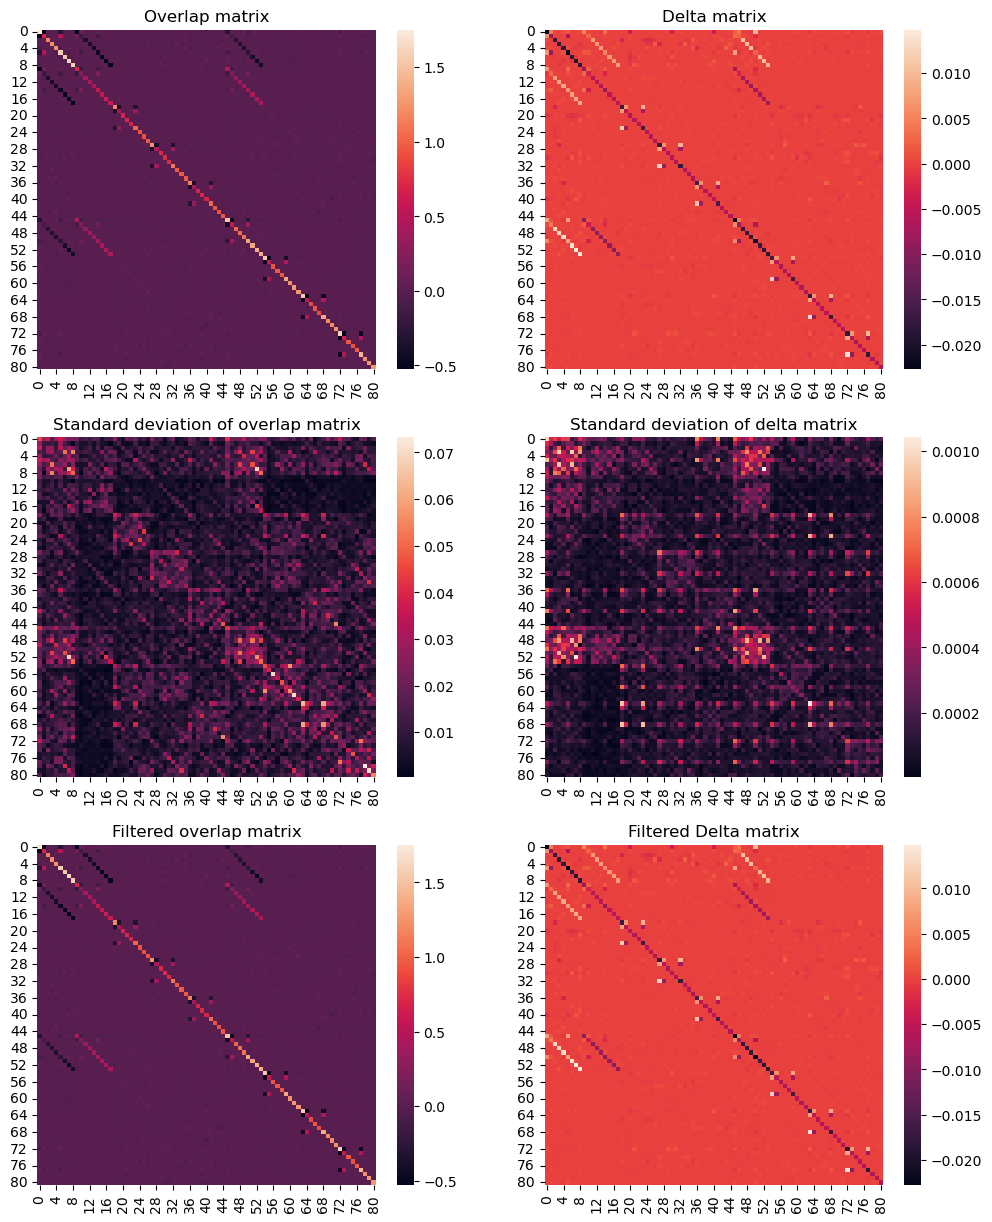

In [239]:
res = plot_delta_ovlp("abvmc-he-9.hdf5")
s, delta = res['filtered']
sinv = np.linalg.inv(s)
m = np.matmul(sinv, delta)
e, v = np.linalg.eigh(m)
(e-e[0]) * 27.211

# Testing Lucas Wagner's code 

In [102]:
import pyqmc.api as pyq


In [103]:
mcc.ci

FCIvector([[ 9.99414547e-01,  3.80945275e-15,  4.95318477e-03],
           [ 4.29717647e-15, -2.21215301e-02,  6.82140535e-16],
           [ 4.95318477e-03,  6.62509855e-16, -2.51422548e-02]])

In [104]:
configs = pyq.initial_guess(mol, 2000)
_, configs = pyq.vmc(wf1, configs)

In [111]:
wfs = []
num_det = mcc.ci.shape[0] * mcc.ci.shape[1]
for i in range(mcc.ci.shape[0]):
    for j in range(mcc.ci.shape[1]):
        mc0 = copy.copy(mcc)
        mc0.ci = mcc.ci * 0
        mc0.ci[i, j] = 1
        wf0, _ = generate_slater(mol, mf, mc=mc0, optimize_determinants=False)
        self.wfs.append(wf0)

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


In [112]:
from sample_many import sample_overlap
from accumulators_multiwf import EnergyAccumulatorMultipleWF

In [113]:
energy = EnergyAccumulatorMultipleWF(pyq.EnergyAccumulator(mol))
data_weighted, data_unweighted, configs = sample_overlap(
        wfs, configs, energy, nsteps=40, nblocks=20
)

In [114]:
y = data_unweighted['overlap']

In [134]:
wfs[1]._det_occup

[[[0], [1], [2]], [[0], [1], [2]]]

In [122]:
# energy = EnergyAccumulatorMultipleWF(pyq.EnergyAccumulator(mol))
# with concurrent.futures.ProcessPoolExecutor(max_workers=ncore) as client:
#     data_weighted, data_unweighted, configs = sample_overlap(
#             wfs, configs, energy, nsteps=40, nblocks=20, client=client
#     )    

In [123]:
discard = 10

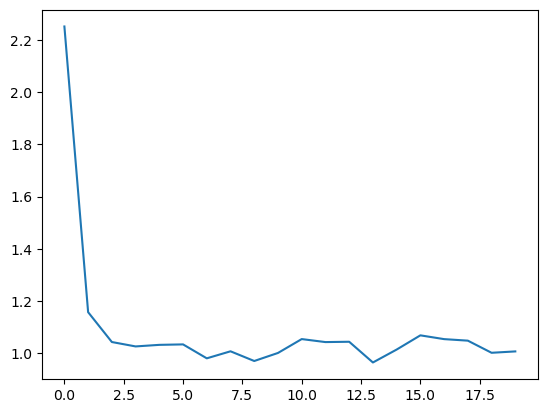

In [135]:
plt.plot(y[:,0,0])

<Axes: >

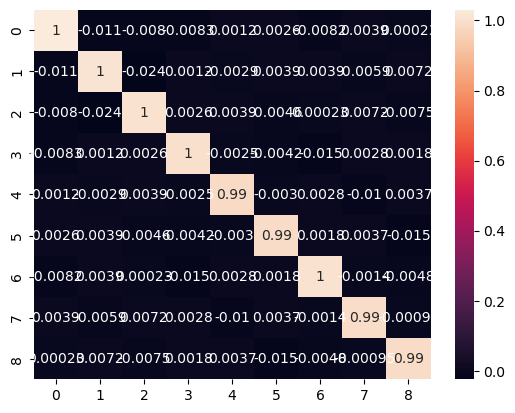

In [124]:
y_avg = np.average(y[discard:], axis=0)
sns.heatmap(y_avg, annot=True)

<Axes: >

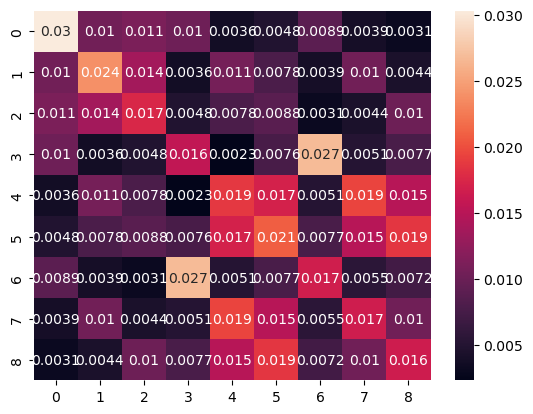

In [125]:
y_std = np.std(y[discard:], axis=0)
sns.heatmap(y_std, annot=True)

<Axes: >

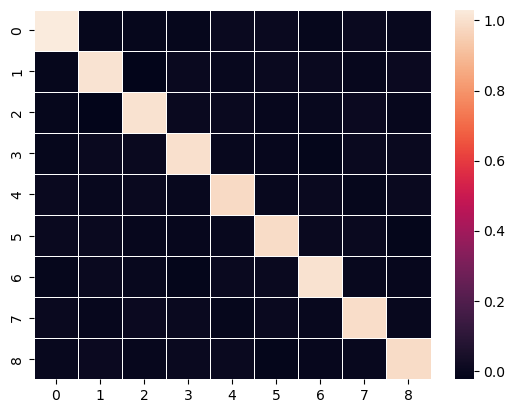

In [126]:
import copy
nom_new = copy.deepcopy(y_avg)
nom_new[y_avg>np.abs(y_avg)] = 0
sns.heatmap(nom_new,  linewidths=.5)